In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


<AxesSubplot:>

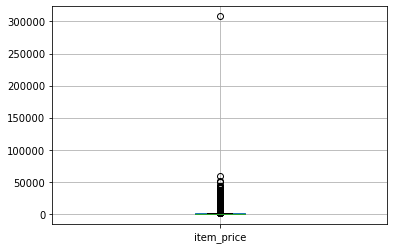

In [8]:
sales.boxplot(column=['item_price'])

In [9]:
lessthanzero = sales[sales.item_price <= 0]
lessthanzero.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
sales_train = sales[(sales.item_price > 0) & (sales.item_price < 300000)]

<AxesSubplot:>

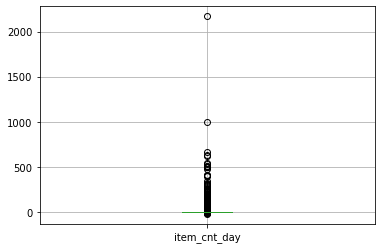

In [11]:
sales_train.boxplot(column=['item_cnt_day'])

In [12]:
sales_train = sales_train[sales_train.item_cnt_day < 750]

<AxesSubplot:>

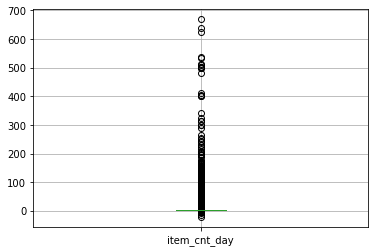

In [13]:
sales_train.boxplot(column=['item_cnt_day'])

In [14]:
## ITEMS DATA PREP

In [15]:
pd.options.display.max_rows = 1000
item_categories.head(100)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [16]:
items = pd.merge(items, item_categories, on='item_category_id')
items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [17]:
items['genre'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино


In [18]:
manual_genre_edit = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители', #Blank Media
            'PC ': 'Аксессуары', ## PC -> Accessories
            'Служебные': 'Служебные ' #Service
            }


items['genre'] = items['genre'].apply(lambda x: manual_genre_edit[x] if x in manual_genre_edit.keys() else x)

In [19]:
items['genre_id'] = LabelEncoder().fit_transform(items['genre'])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre,genre_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,11
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,11
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,11
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,11
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,11


In [20]:
items = items[['item_id', 'item_category_id', 'genre_id']]
items.head()

,item_id,item_category_id,genre_id
0,0,40,11
1,2,40,11
2,3,40,11
3,4,40,11
4,5,40,11


In [21]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [22]:
sales_train.loc[sales_train.shop_id == 57, 'shop_id'] = 0
sales_train.loc[sales_train.shop_id == 58, 'shop_id'] = 1
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40

test.loc[test.shop_id == 57, 'shop_id'] = 0
test.loc[test.shop_id == 58, 'shop_id'] = 1
test.loc[test.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 39, 'shop_id'] = 40


rows = len(sales_train)
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print(rows - len(sales_train))

502311


In [23]:
aggregate_count = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
aggregate_count.columns = ['item_cnt_month']
aggregate_count.reset_index(inplace=True)

aggregate_count.head()    

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [24]:
#aggregate_days_sold = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']})
#aggregate_days_sold.columns = ['days_sold']
#aggregate_days_sold.reset_index(inplace=True)
#aggregate_days_sold.head() 

#cc = aggregate_days_sold.loc[aggregate_days_sold['days_sold'] > 31]
#cc.head()

In [25]:
aggregate_price = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
aggregate_price.columns = ['mean_price']
aggregate_price.reset_index(inplace=True)

aggregate_price.head()

,date_block_num,shop_id,item_id,mean_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [26]:
merged = aggregate_count.merge(aggregate_price, on=['date_block_num','shop_id','item_id'], how='left')
merged.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


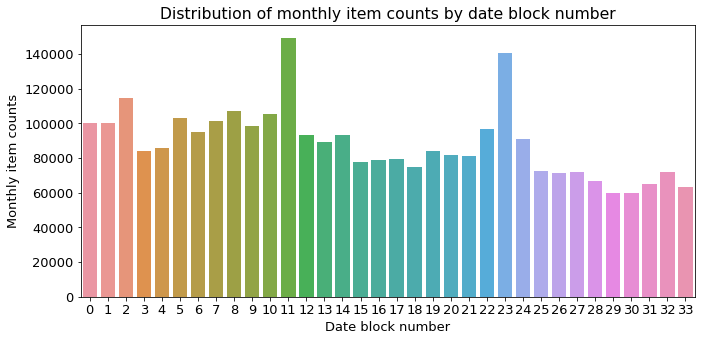

In [27]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = merged.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

In [28]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
merged = pd.concat([merged, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merged.fillna(0, inplace=True)


In [29]:
mx = merged.loc[merged['date_block_num'] == 34]
print(len(mx))
mx.head()
print(len(test))


214200
214200


In [30]:
merged2 = merged.merge(items, on=['item_id'], how='left')
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id
0,0,0,32,6.0,221.0,0.0,40,11
1,0,0,33,3.0,347.0,0.0,37,11
2,0,0,35,1.0,247.0,0.0,40,11
3,0,0,43,1.0,221.0,0.0,40,11
4,0,0,51,2.0,128.5,0.0,57,13


In [31]:
merged2["month_id"] = merged2['date_block_num'].apply(lambda dbn: 1 + dbn % 12)
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id
0,0,0,32,6.0,221.0,0.0,40,11,1
1,0,0,33,3.0,347.0,0.0,37,11,1
2,0,0,35,1.0,247.0,0.0,40,11,1
3,0,0,43,1.0,221.0,0.0,40,11,1
4,0,0,51,2.0,128.5,0.0,57,13,1


In [32]:
month_inspection = sales_train.loc[sales_train["date_block_num"] == 5]
month_inspection = month_inspection.groupby(['date']).agg({'item_cnt_day': ['sum']})
month_inspection = month_inspection.reset_index()

month_inspection["date"] = month_inspection['date'].apply(lambda x: int(x.split('.')[0]) )
month_inspection.head(5)

,date,item_cnt_day
,,sum
0,1,4823.0
1,2,3663.0
2,3,2733.0
3,4,2753.0
4,5,2892.0


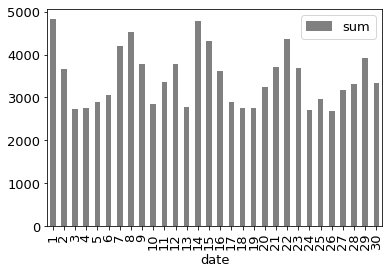

In [33]:
month_inspection.plot.bar(x="date", y="item_cnt_day", color='grey');

In [34]:
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    return weeknd_count
map_dict = {i: count_days(i) for i in range(35)}

merged2['weeknd_count'] = merged2['date_block_num'].apply(lambda x: map_dict[x])
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count
0,0,0,32,6.0,221.0,0.0,40,11,1,4
1,0,0,33,3.0,347.0,0.0,37,11,1,4
2,0,0,35,1.0,247.0,0.0,40,11,1,4
3,0,0,43,1.0,221.0,0.0,40,11,1,4
4,0,0,51,2.0,128.5,0.0,57,13,1,4


In [35]:
def lag_feature(df, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in [1, 2, 3]:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    del tmp
    return df

In [36]:
merged2 = lag_feature(merged2, 'item_cnt_month')
merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']] = merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].fillna(value=0)

In [37]:
merged2.head(500000)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,37,11,1,4,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,40,11,1,4,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,57,13,1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,11,4,7956,2.0,4990.0,0.0,6,1,12,5,1.0,1.0,0.0
499996,11,4,7961,1.0,2290.0,0.0,6,1,12,5,0.0,0.0,0.0
499997,11,4,7965,1.0,1899.0,0.0,33,9,12,5,3.0,2.0,0.0
499998,11,4,7976,1.0,1299.0,0.0,33,9,12,5,1.0,0.0,0.0


In [38]:

y = merged2.loc[ (merged2['date_block_num'] == 0) & (merged2['shop_id'] == 13) & (merged2['item_id'] == 32)]
y.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3


In [39]:
##Add target encoding for item/shop for last 3 months 
##item_id_target_mean = merged2.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    ##"item_cnt_month": "item_shop_target_enc"}, errors="raise")

##merged2 = pd.merge(merged2, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

##merged2.head()

In [40]:
#xm = merged2.loc[merged2['item_cnt_month'] != merged2['item_shop_target_enc']]
#xm.head()


In [44]:
df2 = merged2.loc[merged2['date_block_num'] == 34]
df2.head()


,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
1333650,34,5,5037,0.0,0.0,0.0,19,5,11,5,0.0,1.0,3.0
1333651,34,5,5320,0.0,0.0,1.0,55,13,11,5,0.0,0.0,0.0
1333652,34,5,5233,0.0,0.0,2.0,19,5,11,5,1.0,3.0,1.0
1333653,34,5,5232,0.0,0.0,3.0,23,5,11,5,0.0,0.0,1.0
1333654,34,5,5268,0.0,0.0,4.0,20,5,11,5,0.0,0.0,0.0


In [41]:
df = merged2
X_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)]
Y_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)]['item_cnt_month']

X_valid = df[df.date_block_num == 33]
Y_valid = df[df.date_block_num == 33]['item_cnt_month']

X_test = df[df.date_block_num == 34]

In [ ]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'item_category_id',
                        'genre_id',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=10000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        ##early_stopping_rounds = 500
)

In [ ]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)



submission = pd.DataFrame({ "ID": test.index, "item_cnt_month": Y_test }) 
submission.to_csv('gbm_submissionXYZZ.csv', index=False)

In [ ]:
print(len(Y_test))

In [ ]:
print(len(test))

In [ ]:
test.head()


In [ ]:
print(Y_test)


In [ ]:

print(len(X_test))